In [105]:
# set up basic packages
import numpy as np
import pandas as pd
import astropy.units as u

# set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# set up astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle

from regions import Regions, CircleSkyRegion

In [46]:
# this is the name of the image file
image_file = 'mosaic_nircam_f444w_COSMOS-Web_60mas_J1_v0_2_i2d.fits'

In [47]:
# this opens the HDU list of the .fits files and asks for the information within. SCI is what we'll use
hdu_list = fits.open(image_file)
hdu_list.info()

# this saves the WCS setting to be used later
wcs = WCS(hdu_list[1].header)

Filename: mosaic_nircam_f444w_COSMOS-Web_60mas_J1_v0_2_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     371   ()      
  1  SCI           1 ImageHDU        75   (15000, 18000)   float32   
  2  ERR           1 ImageHDU        10   (15000, 18000)   float32   
  3  CON           1 ImageHDU        10   (15000, 18000, 2)   int32   
  4  WHT           1 ImageHDU         9   (15000, 18000)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (15000, 18000)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (15000, 18000)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (15000, 18000)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [223175B]   


Set DATE-AVG to '2023-01-05T23:31:29.914' from MJD-AVG.
Set DATE-END to '2023-01-06T03:02:51.666' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     7.465942 from OBSGEO-[XYZ].
Set OBSGEO-H to 1695400147.778 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [48]:
image_data = hdu_list[1].data

In [49]:
hdu_list.close()

In [50]:
# this masks the image such that the invalid values are set to NaN
masked_image = np.where(image_data != 0, image_data, np.nan)

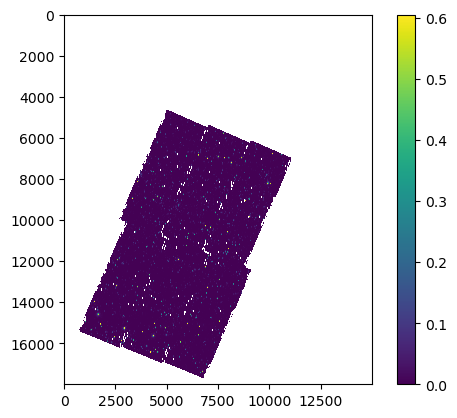

In [51]:
# this uses imshow to get an overview of what the image looks like
plt.imshow(masked_image, vmin = 0., vmax = 5*np.std(image_data))
plt.colorbar()

# save figures
plt.savefig('first_image.png')

In [52]:
# add in some relevant packages
from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks

In [53]:
# this finds peaks in the masked image and returns their coords and values
mean, median, std = sigma_clipped_stats(masked_image, sigma=3.0)

# here we only look for peaks whose signal-to-noise ratio (SNR) is 10 at minimum
threshold = median + (10.0 * std) 
tbl = find_peaks(masked_image, threshold, box_size=11)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output

# print only the first 10 peaks
print(tbl[:10])  

x_peak y_peak  peak_value
------ ------ -----------
  5034   4607  0.19199418
  5134   4666  0.40534496
  5066   4689 0.075550921
  5055   4714 0.076135479
  5000   4723  0.15805697
  4942   4724   5.8360701
  5212   4753  0.16899712
  5119   4758   1.2954279
  5326   4760   0.1489318
  5180   4774 0.097587898


In [54]:
# add in more packages
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

In [55]:
# this transposes all the positions of the peaks into something computable
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))

# this turns all the peaks' positions into apertures of radius 5 pixels, just for the sake of plotting
apertures = CircularAperture(positions, r=5.0)
norm = simple_norm(masked_image, 'sqrt', percent=99.9)

In [56]:
# this turns the list of peak coordinates into a region (an astropy file type, I assume)
# and then writes that region into a .reg file that DS9 can read
coords = pixel_to_skycoord(positions[:,0], positions[:,1], wcs)
regs = Regions([CircleSkyRegion(coords[i], 1.5*u.arcsec) for i in range(len(coords))])
regs.write('cosmosweb_coords.reg', format='ds9')

OSError: cosmosweb_coords.reg already exists